# Self-Driving Car Engineer Nanodegree


## Advanced Lane Finding Project
The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

Apply a distortion correction to raw images.

Use color transforms, gradients, etc., to create a thresholded binary image.

Apply a perspective transform to rectify binary image ("birds-eye view").

Detect lane pixels and fit to find the lane boundary.

Determine the curvature of the lane and vehicle position with respect to center.

Warp the detected lane boundaries back onto the original image.

Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
#!pip install opencv-python
#!conda install -c conda-forge opencv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


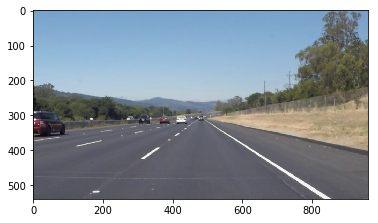

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [1]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# used some code from a previous course I did on udemy: https://github.com/GustavoMoreiraPT/UdemySelfDrivingCars/blob/master/finding-lanes/lanes.py

def make_coordinates(image, line_parameters):
    if(np.isnan(line_parameters).any()):
        return None
    slope, intercept = line_parameters
    y1 = 540
    y2 = 320
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])

def find_big_lines(image, lines):
    big_lines = []
    left_slope = []
    right_slope = []
    
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if(slope < 0):
            left_slope.append((slope, intercept))
        if(slope >= 0):
            right_slope.append((slope, intercept))
            
    left_fit_average = np.average(left_slope, axis = 0)
    right_fit_average = np.average(right_slope, axis = 0)
    
    left_line = np.array([make_coordinates(image, left_fit_average)])
    right_line = np.array([make_coordinates(image, right_fit_average)])

    if(left_line == None or right_line == None):
        return None
    
    big_lines.append(left_line)
    big_lines.append(right_line)
    
    return big_lines
    

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    new_lines = find_big_lines(img, lines)
    
    if(new_lines == None):
        return None
    
    for line in new_lines:
        if(line[0] == None):
            return None
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Compute camera calibration



In [2]:
# Add code for camera calibration here

def calibrate_camera(images_path):
    
    images = glob.glob(images_path)
    
    #define the number of inner corner in both x and y
    nx = 9
    ny = 6
    
    # Arrays to store object ponts and image ponts from all the images
    
    object_points = [] # 3D points in real world space
    image_points = [] # 2D points in image plane space
    
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for image in images:
        #read image into memory
        img = mpimg.imread(image)
        
        #convert to gray scale before applying camera calibration
        # using RGB2GRAY as I used mpimg to read the image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # find corners of chessboard as used in the lessons
        
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        #add result to object_points and image_points if corners were found with sucess
        if ret == True:
            image_points.append(corners)
            object_points.append(objp)
            
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
            cv2.imwrite('images_after_calibration/' + os.path.basename(image), img)
            
    #use open cv calibrate camera function
    # the gray.shape[::-1] means the height and width of the image, as explained in te lesson 6 from camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)
        
    #return mtx and dist only because we only need these parameters to undistort the actual road image
    return mtx, dist
    

## Distortion correction

In [3]:
# Add code for distortion correction here

def undistort_image(image_path, mtx, dist):
    
    image = cv2.imread(image_path)
    
    #apply cv2 function undistort with mtx and dist collected from the camera calibration step
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    
    cv2.imwrite('images_after_undistortion/' + os.path.basename(image_path), dst)
    
    return dst

def undistort_images(images_directory, images_names, mtx, dist):
    
    undistorted_images = []
    
    for img in images_names:
        dst = undistort_image(str(images_directory + img), mtx, dist)
        
        undistorted_images.append(dst)
        
    return undistorted_images
    

## Color and gradient transformation

In [4]:
# Add code for color and gradient transformation here

def get_images_with_hls_channel(images_directory, images_names):
    
    images_with_hls_channel = []
    
    for img in images_names:
        
        image_channels = []
        image = cv2.imread(str(images_directory + img))                 
        hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        h = hls_image[:,:,0]
        l = hls_image[:,:,1]
        s = hls_image[:,:,2]
                           
        image_channels.append(h)
        image_channels.append(l)
        image_channels.append(s)
        cv2.imwrite('images_gradient_h_channel/' + os.path.basename(img), h)
        cv2.imwrite('images_gradient_l_channel/' + os.path.basename(img), l)
        cv2.imwrite('images_gradient_s_channel/' + os.path.basename(img), s)
        
        images_with_hls_channel.append(image_channels)        
        
    return images_with_hls_channel

def extract_s_channel_from_image(image):
    
    hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    s = hls_image[:,:,2]
    return s

def extract_sobel_x_from_image(gray):
        
    # Sobel x as taken from lesson
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sxbinary

def apply_combined_sobelx_and_color_channel_gradient(images_directory, images_names):
    
    channel_processed_images = []
    
    for img in images_names:
        
        image = cv2.imread(str(images_directory + img))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        sxbinary = extract_sobel_x_from_image(gray)
        
        s_channel = extract_s_channel_from_image(image)
        
        # Threshold color channel
        s_thresh_min = 170
        s_thresh_max = 255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        # Stack each channel to view their individual contributions in green and blue respectively
        # This returns a stack of the two binary images, whose components you can see as different colors
        color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        
        height, width = gray.shape
        
        final_region_of_interest_mask = np.zeros_like(combined_binary)
       
        region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
        cv2.fillPoly(final_region_of_interest_mask, [region_of_interest_vertices], 1)
        region_image = cv2.bitwise_and(combined_binary, final_region_of_interest_mask)
        
        cv2.imwrite('images_with_gradients_applied_and_region_of_interest/' + os.path.basename(img), region_image * 255)
        
        channel_processed_images.append(region_image)
        
    return channel_processed_images
        
        

## Perspective transformation

In [53]:
# Add code for perspective transformation here

def warp_images(images, output_folder_path):
    warped_images = []
    minvs = []
    
    for img in images:
        #image = cv2.imread(str(images_directory + img))
        #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        warp_result = warp(img)
        warped_image = warp_result[0]
        Minv = warp_result[2]
        #output_name = str(output_folder_path + img)
        #plt.imshow(warped_image)
        #cv2.imwrite(output_name, warped_image)
        warped_images.append(warped_image)
        minvs.append(Minv)
        
    return warped_images, minvs

def warp(img, src=None, dst=None):

    # Define image size to work with
    img_size = (img.shape[1], img.shape[0])
    
    if src is None:
        src = np.float32(
            [[290,  700],  # Bottom left corner
             [600,  460],  # Top left corner
             [730,  460],  # Top right corner
             [1120, 700]]) # Bottom right corner
        
    if dst is None:
        dst = np.float32(
            [[250,  720],  # Bottom left corner
             [250,    0],  # Top left corner
             [1000,   0],  # Top right corner
             [1000, 720]]) # Bottom right corner 

    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the opposite matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image - uses linear interpolation as defined in opencv and in the lesson from camera calibration
    warped_image = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped_image, M, Minv

## Detect lane pixels and fit to find the lane boundary

In [6]:
# Add code for detect lane pixels and fit to find the lane boundary here

def find_all_histograms(images_directory, images_names):
    
    histograms = []
    
    for img in images_names:
        image = mpimg.imread(str(images_directory + img))
        histogram = hist(image)
        #cv2.imwrite('histograms/' + os.path.basename(img), histogram)
        #plt.plot(histogram)
        histograms.append(histogram)
        
    return histograms

#as in the class
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

def find_lane_pixels(binary_warped, nwindows = 10, margin = 100, minpix = 50):
    
    histogram = hist(binary_warped)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #print(binary_warped)
    #cv2.imwrite('sliding_windows_search/' + str(os.path.basename(binary_warped)), out_img)

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit, out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit, margin = 100):

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
   # plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fitx, right_fitx, ploty, result

## Determine the curvature of the lane and vehicle position with respect to center

In [30]:
# Add code for determine the curvature of the lane and vehicle position with respect to center here

#this code was taken from the lessons, with some slight changes

def measure_curvature_real(ploty, leftx, rightx, image_shape):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
   # ploty = np.linspace(0, image_shape[0] - 1, image_shape[0])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    print(ploty)
    print(leftx)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

## Warp the detected lane boundaries back onto the original image

In [77]:
# Add code for warp the detected lane boundaries back onto the original image here

def compose_image_with_lines(img, warped_img, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    print("Image = " + str(img))
    print("Warped image = " + str(warped_img))
    
    
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    
    #one for each color channel
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    #left_fitx = left_fit[0]
    #right_fitx = right_fit[0]

    points_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points = np.hstack((points_left, points_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([points]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    composed_warp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    weighted_composed_warp = cv2.addWeighted(img, 1, composed_warp, 0.3, 0)
    return weighted_composed_warp

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [11]:
# Add code for output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position here

## Project 2 Pipeline 

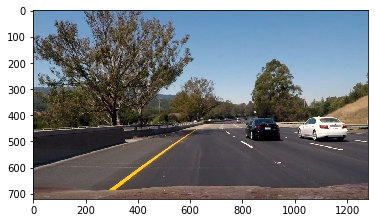

In [79]:
# Add new pipeline here
imagesDir = os.listdir("test_images/") # get the test images 

original_images = []

for img in imagesDir:
    image = image = cv2.imread(str("test_images/" + img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_images.append(image_rgb)

mtx, dist = calibrate_camera('./camera_cal/calibration*.jpg')

undistorted_images = undistort_images("test_images/", imagesDir, mtx, dist)

images_with_hls_channel = get_images_with_hls_channel("images_after_undistortion/", imagesDir)

channel_processed_images = apply_combined_sobelx_and_color_channel_gradient("images_after_undistortion/", imagesDir)

#original_warped_images = warp_images("test_images/", imagesDir, 'original_warped_images/')

#thresholded_warped_images = warp_images("images_with_gradients_applied_and_region_of_interest/", imagesDir, 'thresholded_warped_images/')
result = warp_images(channel_processed_images, 'thresholded_warped_images/')
thresholded_warped_images = result[0]
minvs = result[1]

histograms = find_all_histograms("thresholded_warped_images/", imagesDir)

sliding_windows_images = []
right_fits = []
left_fits = []

for i in range(len(histograms)):
    result = fit_polynomial(thresholded_warped_images[i])
    left_fits.append(result[0])
    right_fits.append(result[1])
    sliding_windows_images.append(result[2])
    
#plt.imshow(sliding_windows_images[2])

optimized_lane_finding = []
left_fits_optimized = []
right_fits_optimized = []
plot_ys = []

for i in range(len(histograms)):
    result = search_around_poly(thresholded_warped_images[i], left_fits[i], right_fits[i])
    optimized_lane_finding.append(result[3])
    left_fits_optimized.append(result[0])
    right_fits_optimized.append(result[1])
    plot_ys.append(result[2])

#plt.imshow(optimized_lane_finding[2])

composed_images = []

for i in range(len(original_images)):
    composed = compose_image_with_lines(original_images[i], thresholded_warped_images[i], left_fits_optimized[i], right_fits_optimized[i], plot_ys[i][0], minvs[i])
    composed_images.append(composed)
    
plt.imshow(composed_images[7])



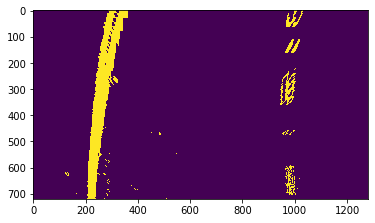

In [72]:
plt.imshow(thresholded_warped_images[4])

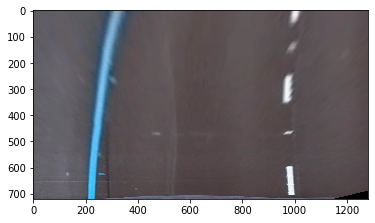

In [59]:
plt.imshow(original_warped_images[4])

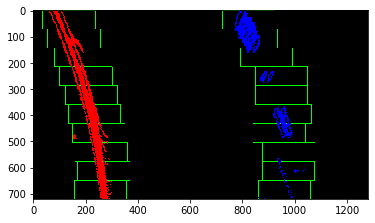

In [71]:
plt.imshow(sliding_windows_images[3])

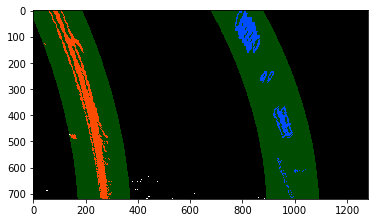

In [72]:
plt.imshow(optimized_lane_finding[3])

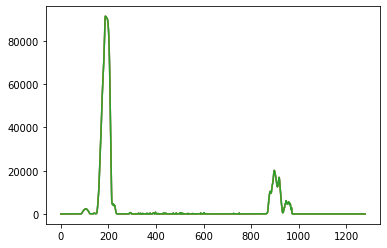

In [17]:
histograms = find_all_histograms("thresholded_warped_images/", imagesDir)

plt.plot(histograms[0])

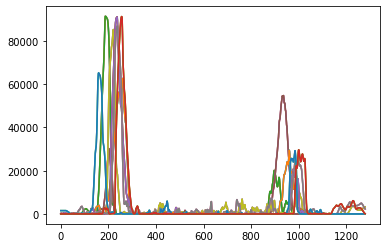

In [62]:
histograms = find_all_histograms("thresholded_warped_images/", imagesDir)

for histogram in histograms:
    plt.plot(histogram)

In [31]:
#printing curvatures for testing purposes

for i in range(len(optimized_lane_finding)):
    #curvatures = measure_curvature_real(plot_ys[i], left_fits[i], right_fits[i], optimized_lane_finding[i].shape)
    
    curvatures = measure_curvature_pixels(plot_ys[i], left_fits[i], right_fits[i])
    # Print the results
    print('Left line curvature:', curvatures[0], 'm')
    print('Right line curvature:', curvatures[1], 'm')

Left line curvature: 64323.19038481351 m
Right line curvature: 14086.886896486623 m
Left line curvature: 15506.16965971646 m
Right line curvature: 103567.91415078439 m
Left line curvature: 2234.3396160767606 m
Right line curvature: 4202.769663053188 m
Left line curvature: 1917.254711516056 m
Right line curvature: 1422.420743508508 m
Left line curvature: 3477.7385067588716 m
Right line curvature: 2883.51834738613 m
Left line curvature: 8225.350267545502 m
Right line curvature: 3095.670429171411 m
Left line curvature: 2290.7320500078504 m
Right line curvature: 5036.217045709577 m
Left line curvature: 3582.724430885191 m
Right line curvature: 2397.738763422948 m


In [81]:
import os
os.listdir("test_images/")

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [63]:
import copy 
def process_image_with_drawing_lines(original_image):
    image = copy.copy(original_image)
    gray = grayscale(image)
    gaussian_image = gaussian_blur(gray, 5)
    edges = canny(gaussian_image, 50, 150)
    imshape = image.shape
    vertices = np.array([[(180,imshape[0]),(470, 300), (500, 285), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    line_image = hough_lines(img=masked_edges, rho=2, theta=np.pi/180, threshold=15, min_line_len=30, max_line_gap=5)
    weighted_image = weighted_img(original_image, line_image)
    
    return weighted_image

In [64]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
import os

if not os.path.exists('test_images_output/'):
    os.makedirs('test_images_output/')

# start array of images
imagesDir = os.listdir("test_images/")

preprocessed_images = []
for i in range(len(imagesDir)):
    original_image = (mpimg.imread('test_images/' + imagesDir[i]))
    image_with_lines = process_image_with_drawing_lines(original_image)
    cv2.imwrite('test_images_output/' + imagesDir[i], image_with_lines)
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [13]:
# Import everything needed to edit/save/watch video clips
#!pip install moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [44]:
previous_image = None

def process_image(image):
   
    result = process_image_with_drawing_lines(image)
    if(result == None):
        return previous_image
    else:
        previous_image = result
        return result

Let's try the one with the solid white lane on the right first ...

In [56]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



100%|█████████▉| 221/222 [00:14<00:00, 13.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.64 s, sys: 208 ms, total: 3.85 s
Wall time: 16 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [58]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [65]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,15)
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



100%|█████████▉| 375/376 [00:23<00:00, 14.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 4.53 s, sys: 378 ms, total: 4.91 s
Wall time: 25.5 s


In [66]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))